In [114]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

In [115]:
dataset = pd.read_csv("../2019-2023full_data/data_info_main_par.csv")
dataset["Time"] = pd.to_datetime(dataset["Time"])
# 根据日期（天）对数据进行分组，并计算每一天的平均气温
daily_average = dataset.groupby(dataset["Time"].dt.date).agg({"Temperature": "mean", "Relative Humidity": "mean"}).reset_index()

# 创建一个新的DataFrame，包含日期和对应的平均气温
new_data = pd.DataFrame({"Time": daily_average["Time"], "Temperature": daily_average["Temperature"],"Relative Humidity": daily_average["Relative Humidity"]})
new_data["THI"] = 0.81 * new_data["Temperature"] + 0.01 * 0.01 * new_data["Relative Humidity"] * (0.99 * new_data["Temperature"] - 14.3) + 46.3
# 将Time列转换为日期类型
new_data['Time'] = pd.to_datetime(new_data['Time']).dt.date
new_data

,Time,Temperature,Relative Humidity,THI
0,2019-07-31,26.095238,91.500000,67.542682
1,2019-08-01,26.515152,93.545455,67.889060
2,2019-08-02,26.906250,91.500000,68.206948
3,2019-08-03,26.642857,91.750000,67.991516
4,2019-08-04,27.750000,82.875000,68.886667
...,...,...,...,...
1561,2023-11-08,25.000000,76.958333,66.630421
1562,2023-11-09,25.625000,81.083333,67.145999
1563,2023-11-10,26.958333,82.291667,68.238199
1564,2023-11-11,25.208333,84.750000,66.809062


In [116]:
data_2020 = new_data[new_data["Time"].astype(str).str[:4] == '2020']
new_data_2020 = pd.DataFrame({"Time": data_2020["Time"], "Temperature": data_2020["Temperature"],"Relative Humidity": data_2020["Relative Humidity"]}).reset_index().drop("index",axis=1)
new_data_2020["Time"] = new_data_2020["Time"].astype(str).str[-5:]
new_data_2020.drop(59,inplace=True)
new_data_2020

,Time,Temperature,Relative Humidity
0,01-01,17.750000,80.250000
1,01-02,18.416667,77.916667
2,01-03,18.916667,81.500000
3,01-04,19.208333,82.958333
4,01-05,19.833333,78.833333
...,...,...,...
361,12-27,20.375000,71.875000
362,12-28,20.583333,68.500000
363,12-29,20.916667,74.791667
364,12-30,15.541667,51.708333


In [117]:
data_2021 = new_data[new_data["Time"].astype(str).str[:4] == '2021']
new_data_2021 = pd.DataFrame({"Time": data_2021["Time"], "Temperature": data_2021["Temperature"],"Relative Humidity": data_2021["Relative Humidity"]}).reset_index().drop("index",axis=1)
new_data_2021["Time"] = new_data_2021["Time"].astype(str).str[-5:]

In [118]:
data_2022 = new_data[new_data["Time"].astype(str).str[:4] == '2022']
new_data_2022 = pd.DataFrame({"Time": data_2022["Time"], "Temperature": data_2022["Temperature"],"Relative Humidity": data_2022["Relative Humidity"]}).reset_index().drop("index",axis=1)
new_data_2022["Time"] = new_data_2022["Time"].astype(str).str[-5:]

In [119]:
data_2023 = new_data[new_data["Time"].astype(str).str[:4] == '2023']
new_data_2023 = pd.DataFrame({"Time": data_2023["Time"], "Temperature": data_2023["Temperature"],"Relative Humidity": data_2023["Relative Humidity"]}).reset_index().drop("index",axis=1)
new_data_2023["Time"] = new_data_2023["Time"].astype(str).str[-5:]

### **并行计算处理数据**

In [120]:
from joblib import Parallel, delayed

def process_year(year):
    data_year = new_data[new_data["Time"].astype(str).str[:4] == str(year)]
    new_data_year = pd.DataFrame({"Time": data_year["Time"], "Temperature": data_year["Temperature"], "Relative Humidity": data_year["Relative Humidity"]}).reset_index()
    new_data_year["Time"] = new_data_year["Time"].astype(str).str[-5:]
    new_data_year.drop(59, inplace=True)
    return new_data_year

years = [2020, 2021, 2022, 2023]
new_data_years = Parallel(n_jobs=-1)(delayed(process_year)(year) for year in years)
new_data_years

[     index   Time  Temperature  Relative Humidity
 0      154  01-01    17.750000          80.250000
 1      155  01-02    18.416667          77.916667
 2      156  01-03    18.916667          81.500000
 3      157  01-04    19.208333          82.958333
 4      158  01-05    19.833333          78.833333
 ..     ...    ...          ...                ...
 361    515  12-27    20.375000          71.875000
 362    516  12-28    20.583333          68.500000
 363    517  12-29    20.916667          74.791667
 364    518  12-30    15.541667          51.708333
 365    519  12-31    10.791667          37.541667
 
 [365 rows x 4 columns],
      index   Time  Temperature  Relative Humidity
 0      520  01-01    11.782609          40.000000
 1      521  01-02    13.750000          50.708333
 2      522  01-03    16.565217          64.217391
 3      523  01-04    18.208333          65.916667
 4      524  01-05    18.875000          65.208333
 ..     ...    ...          ...                ...
 360

### **找出气温变化极值,并找出时间段内温度变化大于4摄氏度的数据**

In [121]:
import pandas as pd
from scipy.signal import find_peaks

def find_extrema(df, column):
    #寻找极大值
    peaks, _ = find_peaks(df[column])
    maxima = df.iloc[peaks]

    #寻找极小值：对数据取反，然后再寻找极大值
    valleys, _ = find_peaks(-df[column])
    minima = df.iloc[valleys]

    return maxima, minima


In [122]:
#计算出温度变化大于flag的dataframe
def compute_temperature_diff(new_data,s,flag):
    maxima, minima = find_extrema(new_data, s)
    temperature_diff = pd.concat([maxima, minima], axis=0).reset_index().drop("index",axis=1).drop("Relative Humidity",axis=1)
    temperature_diff = temperature_diff.sort_values(by="Time", key=lambda x: pd.to_datetime(x, format="%m-%d")).reset_index().drop("index",axis=1)
    temperature_diff["Previous Day"] = temperature_diff["Time"].shift(1)
    temperature_diff["Temperature Previous Day"] = temperature_diff["Temperature"].shift(1)
    temperature_diff["Temperature Difference"] = temperature_diff["Temperature"] - temperature_diff["Temperature"].shift(1)
    temperature_diff["abs Temperature Difference"] = abs(temperature_diff["Temperature Difference"])
    temperature_diff = temperature_diff[temperature_diff["abs Temperature Difference"] >= flag].reset_index().drop("index",axis=1)
    return  temperature_diff

In [123]:
flag = 4
temperature_diff_2020 = compute_temperature_diff(new_data_2020,'Temperature',flag)
temperature_diff_2021 = compute_temperature_diff(new_data_2021,'Temperature',flag)
temperature_diff_2022 = compute_temperature_diff(new_data_2022,'Temperature',flag)
temperature_diff_2023 = compute_temperature_diff(new_data_2023,'Temperature',flag)

In [124]:
temperature_diff_2020

,Time,Temperature,Previous Day,Temperature Previous Day,Temperature Difference,abs Temperature Difference
0,01-23,22.041667,01-20,17.875000,4.166667,4.166667
1,01-28,12.954545,01-23,22.041667,-9.087121,9.087121
2,02-03,18.173913,01-28,12.954545,5.219368,5.219368
3,02-17,13.652174,02-15,20.826087,-7.173913,7.173913
4,02-22,20.083333,02-17,13.652174,6.431159,6.431159
5,02-26,23.333333,02-23,19.304348,4.028986,4.028986
6,03-10,23.583333,03-05,18.166667,5.416667,5.416667
7,03-11,19.260870,03-10,23.583333,-4.322464,4.322464
8,03-29,20.333333,03-27,24.380952,-4.047619,4.047619
9,04-11,22.333333,04-06,17.041667,5.291667,5.291667


In [125]:
temperature_diff_2021

,Time,Temperature,Previous Day,Temperature Previous Day,Temperature Difference,abs Temperature Difference
0,01-08,9.208333,01-05,18.875000,-9.666667,9.666667
1,01-16,17.583333,01-11,10.583333,7.000000,7.000000
2,01-22,20.291667,01-18,14.166667,6.125000,6.125000
3,02-02,20.875000,01-30,16.625000,4.250000,4.250000
4,02-10,16.500000,02-06,20.666667,-4.166667,4.166667
5,02-15,21.083333,02-10,16.500000,4.583333,4.583333
6,03-22,17.833333,03-20,24.958333,-7.125000,7.125000
7,03-25,22.041667,03-22,17.833333,4.208333,4.208333
8,03-30,26.541667,03-26,21.708333,4.833333,4.833333
9,04-05,22.625000,04-03,26.958333,-4.333333,4.333333


In [126]:
temperature_diff_2022

,Time,Temperature,Previous Day,Temperature Previous Day,Temperature Difference,abs Temperature Difference
0,02-01,14.083333,01-27,19.875000,-5.791667,5.791667
1,02-20,8.583333,02-18,15.708333,-7.125000,7.125000
2,03-01,21.750000,02-20,8.583333,13.166667,13.166667
3,03-14,24.125000,03-08,17.583333,6.541667,6.541667
4,03-24,17.583333,03-22,22.916667,-5.333333,5.333333
5,03-26,26.375000,03-24,17.583333,8.791667,8.791667
6,03-28,17.541667,03-26,26.375000,-8.833333,8.833333
7,03-31,24.333333,03-28,17.541667,6.791667,6.791667
8,04-02,15.083333,03-31,24.333333,-9.250000,9.250000
9,04-08,23.708333,04-02,15.083333,8.625000,8.625000


In [127]:
temperature_diff_2023

,Time,Temperature,Previous Day,Temperature Previous Day,Temperature Difference,abs Temperature Difference
0,01-14,22.708333,01-11,18.083333,4.625000,4.625000
1,01-16,12.500000,01-14,22.708333,-10.208333,10.208333
2,01-20,17.541667,01-16,12.500000,5.041667,5.041667
3,01-25,12.416667,01-23,18.791667,-6.375000,6.375000
4,02-01,19.916667,01-29,12.791667,7.125000,7.125000
5,02-15,16.333333,02-13,22.500000,-6.166667,6.166667
6,02-19,22.791667,02-15,16.333333,6.458333,6.458333
7,02-22,16.958333,02-19,22.791667,-5.833333,5.833333
8,03-24,25.416667,03-19,20.695652,4.721014,4.721014
9,03-28,18.583333,03-24,25.416667,-6.833333,6.833333


### 并行化

In [128]:
# from concurrent.futures import ProcessPoolExecutor
# 
# #计算出温度变化大于flag的dataframe
# def compute_temperature_diff_parallel(new_data,s,flag):
#     maxima, minima = find_extrema(new_data, s)
#     temperature_diff = pd.concat([maxima, minima], axis=0).reset_index().drop("index",axis=1).drop("Relative Humidity",axis=1)
#     temperature_diff = temperature_diff.sort_values(by="Time", key=lambda x: pd.to_datetime(x, format="%m-%d")).reset_index().drop("index",axis=1)
#     temperature_diff["Previous Day"] = temperature_diff["Time"].shift(1)
#     temperature_diff["Temperature Previous Day"] = temperature_diff["Temperature"].shift(1)
#     temperature_diff["Temperature Difference"] = temperature_diff["Temperature"] - temperature_diff["Temperature"].shift(1)
#     temperature_diff["abs Temperature Difference"] = abs(temperature_diff["Temperature Difference"])
#     temperature_diff = temperature_diff[temperature_diff["abs Temperature Difference"] >= flag].reset_index().drop("index",axis=1)
#     return  temperature_diff
# 
# # 并行执行函数
# def run_parallel_computations(data_list, s, flag):
#     with ProcessPoolExecutor() as executor:
#         results = executor.map(compute_temperature_diff_parallel, data_list, [s]*len(data_list), [flag]*len(data_list))
#     return list(results)
# 
# # 假设 new_data_2020, new_data_2021, new_data_2022, new_data_2023 是已经定义好的数据
# data_list = [new_data_2020, new_data_2021, new_data_2022, new_data_2023]
# s = 'Temperature'
# flag = 6
# 
# # 获取并行计算结果
# results = run_parallel_computations(data_list, s, flag)
# 
# # results 中包含了四个数据集的结果
# temperature_diff_2020, temperature_diff_2021, temperature_diff_2022, temperature_diff_2023 = results

In [129]:
def find_highlight_days_index(temperature_diff,new_data):
    days = list(temperature_diff["Time"])
    previous_days = list(temperature_diff["Previous Day"])
    highlighted_intervals = []
    for i in range(len(days)):
        end = new_data[new_data['Time'] == days[i]].index[0]
        start = new_data[new_data['Time'] == previous_days[i]].index[0]
        highlighted_intervals.append((start,end))
    return highlighted_intervals

In [130]:
highlighted_intervals_2020 = find_highlight_days_index(temperature_diff_2020,new_data_2020)
highlighted_intervals_2021 = find_highlight_days_index(temperature_diff_2021,new_data_2021)
highlighted_intervals_2022 = find_highlight_days_index(temperature_diff_2022,new_data_2022)
highlighted_intervals_2023 = find_highlight_days_index(temperature_diff_2023,new_data_2023)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


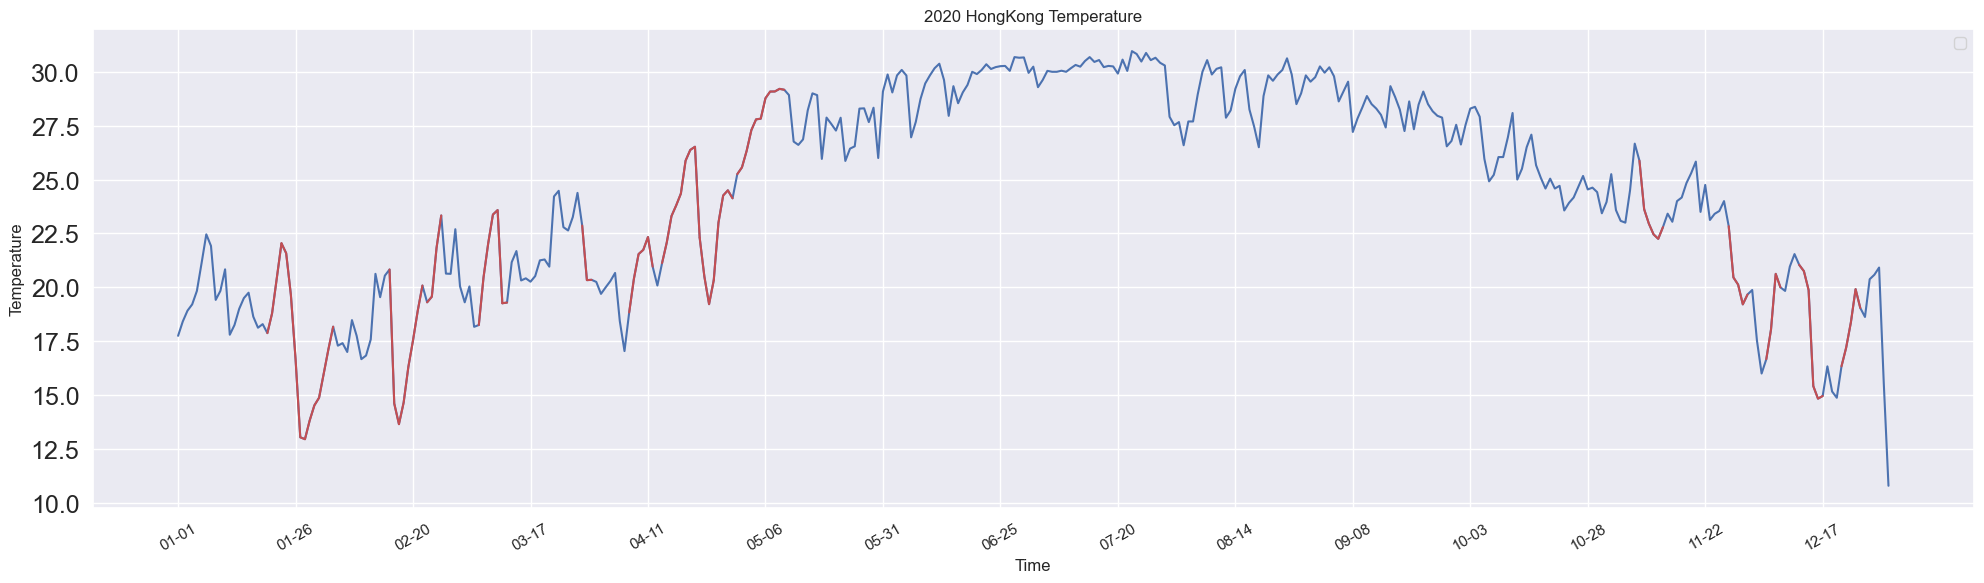

In [131]:
plt.figure(figsize=(20, 6))
plt.plot(new_data_2020["Time"],new_data_2020["Temperature"],color = 'b')
for start, end in highlighted_intervals_2020:
    plt.plot(new_data_2020['Time'].iloc[start:end + 1], new_data_2020['Temperature'].iloc[start:end + 1], color='r')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2020 HongKong Temperature")
# 显示图形
plt.xticks(range(0,len(new_data_2020["Time"]),25),rotation=30)
plt.yticks(size=18)
plt.tight_layout()
# 添加图例
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


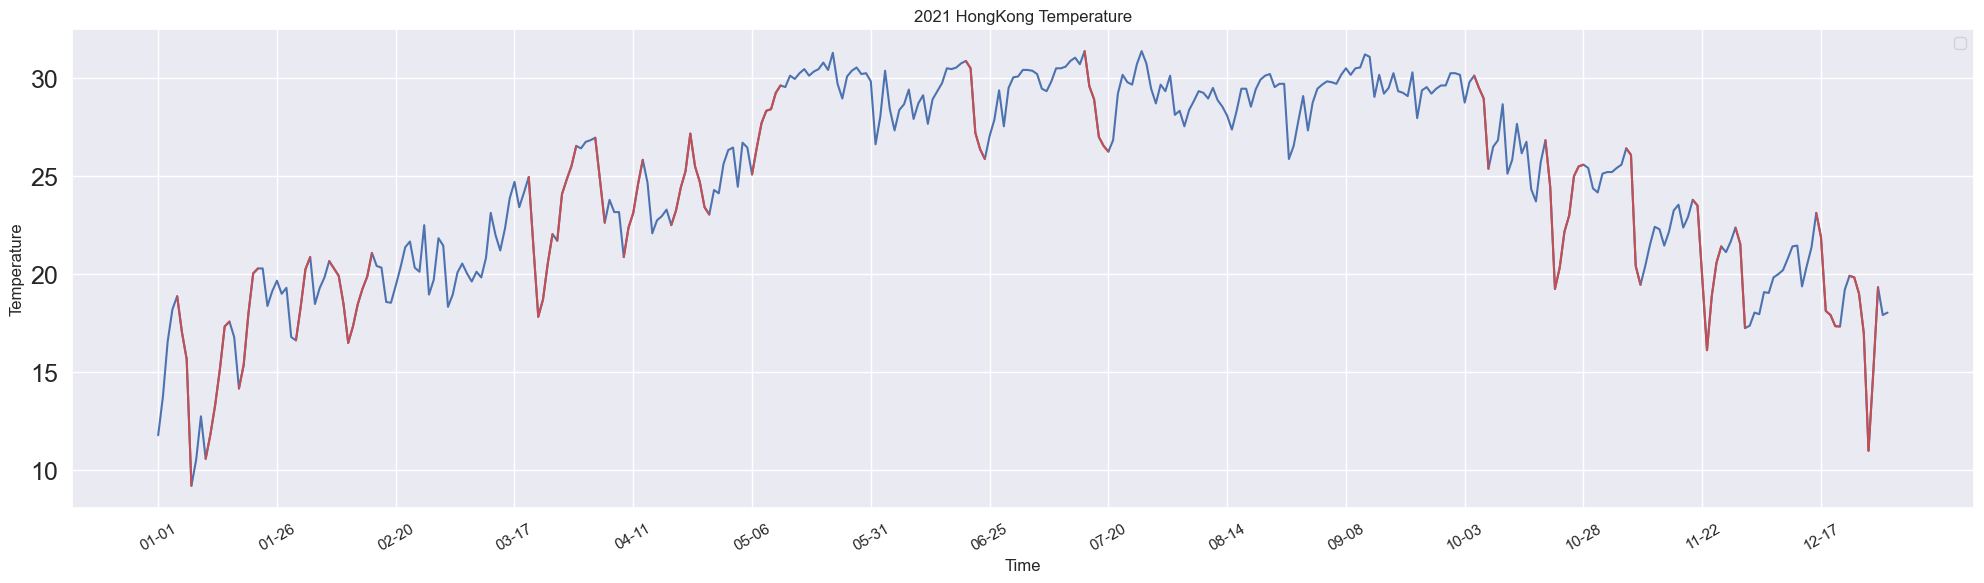

In [132]:
plt.figure(figsize=(20, 6))
plt.plot(new_data_2021["Time"],new_data_2021["Temperature"],color = 'b')
for start, end in highlighted_intervals_2021:
    plt.plot(new_data_2021['Time'].iloc[start:end + 1], new_data_2021['Temperature'].iloc[start:end + 1], color='r')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2021 HongKong Temperature")
# 显示图形
plt.xticks(range(0,len(new_data_2021["Time"]),25),rotation=30)
plt.yticks(size=18)
plt.tight_layout()
# 添加图例
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


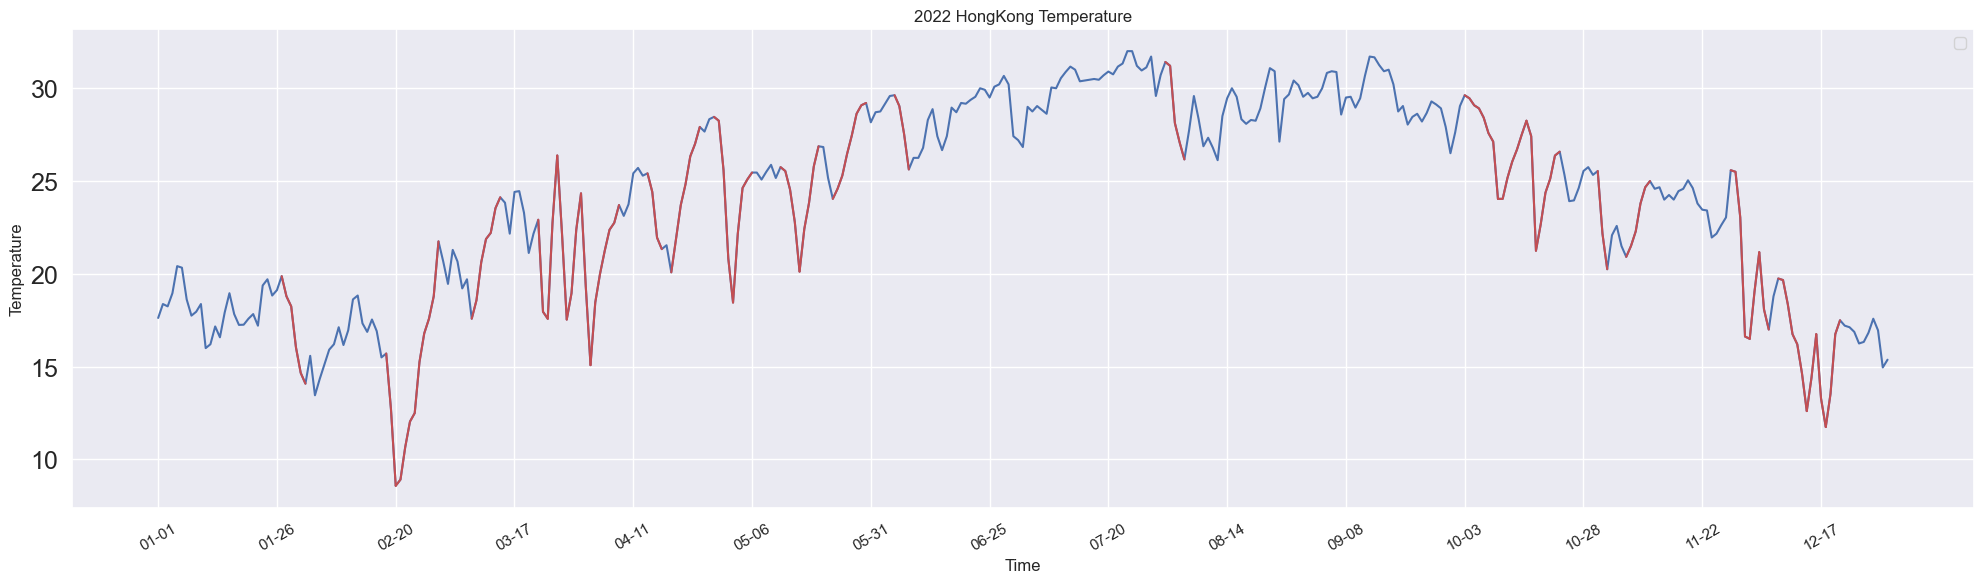

In [133]:
plt.figure(figsize=(20, 6))
plt.plot(new_data_2022["Time"],new_data_2022["Temperature"],color = 'b')
for start, end in highlighted_intervals_2022:
    plt.plot(new_data_2022['Time'].iloc[start:end + 1], new_data_2022['Temperature'].iloc[start:end + 1], color='r')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2022 HongKong Temperature")
# 显示图形
plt.xticks(range(0,len(new_data_2022["Time"]),25),rotation=30)
plt.yticks(size=18)
plt.tight_layout()
# 添加图例
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


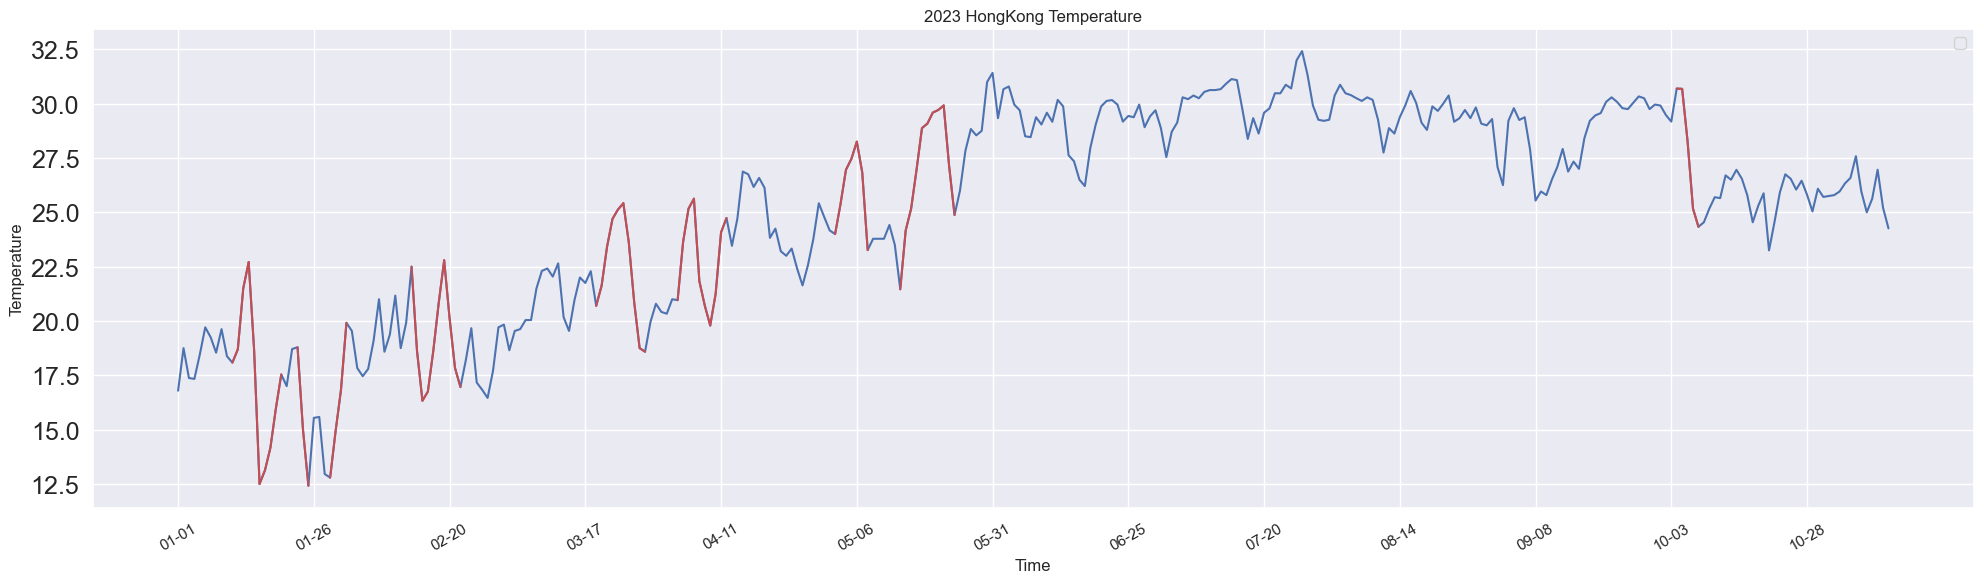

In [134]:
plt.figure(figsize=(20, 6))
plt.plot(new_data_2023["Time"],new_data_2023["Temperature"],color = 'b')
for start, end in highlighted_intervals_2023:
    plt.plot(new_data_2023['Time'].iloc[start:end + 1], new_data_2023['Temperature'].iloc[start:end + 1], color='r')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2023 HongKong Temperature")
# 显示图形
plt.xticks(range(0,len(new_data_2023["Time"]),25),rotation=30)
plt.yticks(size=18)
plt.tight_layout()
# 添加图例
plt.legend()
plt.show()